# Probability Distributions and Bayesian Networks

## Problem:

This project introduces probability distributions of several variables pertaining US Universities obtained from US News and World Report. 
The task at hand is to find a Bayesian Network correlating them with a joint probability distribution, such that it's log likelihood is better than that of data if the variables are independent. 

Before constructing the Bayesian Network, we explore the basic statistical properties of the variables, such as: Mean, Variance, Standard Deviation of each variable and a covariance and correlation matrix to analyze the behavior of the variable and try to find a correlation among them. 
We also compute the log-likelihood of the variables assuming them to be independent and mutually exclusive. This gives us a benchmark to optimize the variables correlation. 
We use some intuition and exhaustive conditional probabilities of all variables to find the required Bayesian Network. Thus, we are trying to find the best BN representation of the variables in agreement with the data provided.

## Step 1. Reading the Data from Excel Sheet

In [4]:
%matplotlib inline
from report_utils import *

In [5]:
fname = 'data/university data.xlsx'

xl_workbook = xl_read.open_workbook(fname)
xl_sheet = xl_workbook.sheet_by_index(0)

num_cols = xl_sheet.ncols
num_rows = xl_sheet.nrows

cs_score_ind = 2
res_overhead_ind = 3
base_pay_ind = 4
tuition_ind = 5

#### We use the xlrd library for reading excel sheet provided to us. The above segment makes a connection to the specific sheet of given excel workbook, where our data is stored.

#### The below segment of code, reads the data from the excel sheet column by column, and we extract the data corresponding to the 4 Random Variables of Interest:

1. CS Score
2. Research Overhead
3. Administrator Base Salary
4. Tuition Fee (Out-of-State)

#### While extracting the data for each variable, we also calculate important statistics along with each variable such as the mean, variance and the standard deviation of each variable.

In [6]:
cs_score_avg, cs_score_var, cs_score_std, cs_score_vec = calc_values_column(cs_score_ind, num_rows, xl_sheet)
res_overhead_avg, res_overhead_var, res_overhead_std, res_overhead_vec = calc_values_column(res_overhead_ind, num_rows, xl_sheet)
base_pay_avg, base_pay_var, base_pay_std, base_pay_vec = calc_values_column(base_pay_ind, num_rows, xl_sheet)
tuition_avg, tuition_var, tuition_std, tuition_vec = calc_values_column(tuition_ind, num_rows, xl_sheet)

X = np.vstack([cs_score_vec, res_overhead_vec, base_pay_vec, tuition_vec])

Now let us try and view the data that we are tackling. In next segment, we are printing the first 10 rows of the data we extracted above.  

In [7]:
df = {'CS Scores':pd.Series(X[0]), 'Admin Base Salary':pd.Series(X[2]), 'Research Overhead': pd.Series(X[1]), 'Tuition': pd.Series(X[3])}
print pd.DataFrame(df)[:10]

   Admin Base Salary  CS Scores  Research Overhead  Tuition
0             400400        5.0               57.0    25064
1             512500        4.6               58.6    30228
2             550000        4.5               54.5    33513
3             440000        4.3               55.9    30698
4             628190        4.3               55.0    34722
5             437000        4.2               53.0    26660
6             416000        4.1               54.0    35580
7             603357        4.1               55.0    41811
8             376827        4.0               55.0    36180
9             459000        4.0               52.0    29720


### Let us describe the data we obtained statistically, by printing out the important features of each variable, such as mean, std, etc. 

In [8]:
pd.DataFrame(df).describe()

,Admin Base Salary,CS Scores,Research Overhead,Tuition
count,49.000000,49.000000,49.000000,49.000000
mean,469178.816327,3.214286,53.385714,29711.959184
std,119120.614593,0.676387,3.584748,5600.687082
min,188294.000000,2.400000,45.000000,20816.000000
25%,400000.000000,2.600000,51.000000,26030.000000
50%,464946.000000,3.100000,53.500000,28813.000000
75%,526549.000000,3.600000,55.000000,33624.000000
max,851303.000000,5.000000,61.000000,42184.000000


## Step 2. Finding Correlation among Variables

#### In this section, we shall be visualising different aspects of the random variables, in order to learn more about the correlation between the variables.

#### 1. Covariance Matrix
First we calculate the covariance matrix of the 4 random variables, and visualise it below.

[[  4.57500000e-01   1.10562500e+00   3.87978185e+03   1.05847976e+03]
 [  1.10562500e+00   1.28504167e+01   7.02793765e+04   2.80578899e+03]
 [  3.87978185e+03   7.02793765e+04   1.41897208e+10  -1.63685641e+08]
 [  1.05847976e+03   2.80578899e+03  -1.63685641e+08   3.13676958e+07]]


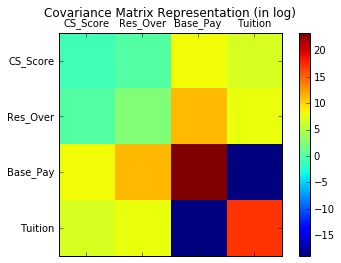

In [9]:
alpha = ['CS_Score', 'Res_Over', 'Base_Pay', 'Tuition']
cov_X = np.cov(X)
print cov_X
plot_values = []
for i in cov_X:
    row = []
    for j in i:
        if j>0:
            row.append(np.log(j))
        else:
            row.append(-1 * np.log(-j))
    plot_values.append(row)
plot_values = np.vstack(plot_values)
fig1 = plt.figure()
plt.title('Covariance Matrix Representation (in log)')
ax1 = fig1.add_subplot(111)
cax1 = ax1.matshow(plot_values, interpolation='nearest')
fig1.colorbar(cax1)

ax1.set_xticklabels(['']+alpha)
ax1.set_yticklabels(['']+alpha)
plt.show()

#### 2. Correlation Matrix
We will do similar steps, for calculating the Correlation Matrix as well. This measure further clarifies the correlation between different variables.

Correlation Matrix = 
[[ 1.          0.4559883   0.04815316  0.27941242]
 [ 0.4559883   1.          0.16458201  0.13975105]
 [ 0.04815316  0.16458201  1.         -0.2453479 ]
 [ 0.27941242  0.13975105 -0.2453479   1.        ]]


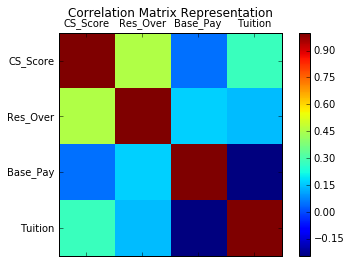

In [10]:
print "Correlation Matrix = "
print np.corrcoef(X)
fig = plt.figure()
plt.title('Correlation Matrix Representation')
ax = fig.add_subplot(111)
cax = ax.matshow(np.corrcoef(X), interpolation='nearest')
fig.colorbar(cax)

ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)

### As we see above, 'Research Overhead' and 'CS Score' are strongly correlated variables. 

#### 3. Pairwise Visualisation of Data

##### A. CS Score

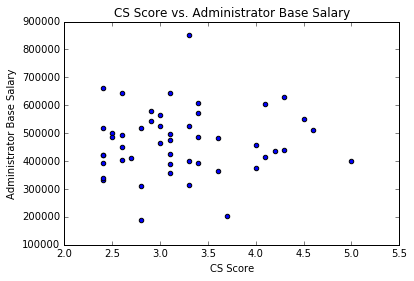

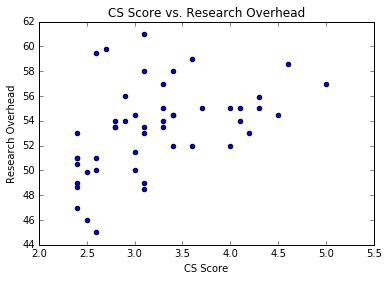

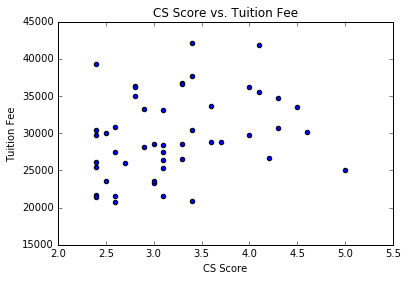

In [11]:
plot_vector_pairs_scatter(cs_score_vec, base_pay_vec, "CS Score", "Administrator Base Salary", "CS Score vs. Administrator Base Salary")
plot_vector_pairs_scatter(cs_score_vec, res_overhead_vec, "CS Score", "Research Overhead", "CS Score vs. Research Overhead")
plot_vector_pairs_scatter(cs_score_vec, tuition_vec, "CS Score", "Tuition Fee", "CS Score vs. Tuition Fee")

From the above plots, research overhead seems to be strongly correlated to CS Score. As Research Overhead percent increases for the Universities, their CS ranking scores also increase. The correlation matrix also agrees with our hypothesis.

Also, we see that the Tuition fee tends to increase with CS Scores.

##### B. Research Overhead

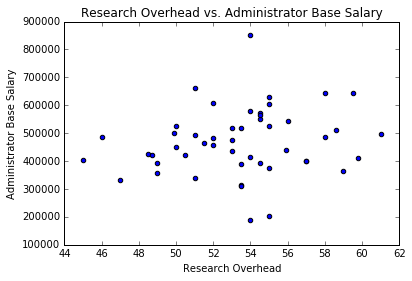

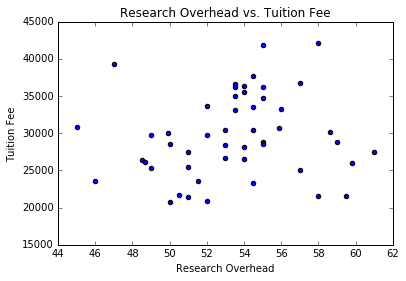

In [12]:
plot_vector_pairs_scatter(res_overhead_vec, base_pay_vec, "Research Overhead", "Administrator Base Salary", "Research Overhead vs. Administrator Base Salary")
plot_vector_pairs_scatter(res_overhead_vec, tuition_vec, "Research Overhead", "Tuition Fee", "Research Overhead vs. Tuition Fee")

Again, from the above plots, we can infer that Research Overhead is proportional to the AdminBasePay. As the pay increases, the Research Overhead increases as observed in the plot above.

##### C. Administrator Base Salary

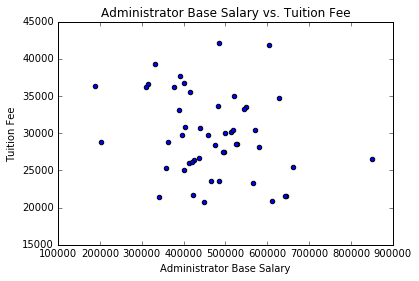

In [13]:
plot_vector_pairs_scatter(base_pay_vec, tuition_vec, "Administrator Base Salary", "Tuition Fee", "Administrator Base Salary vs. Tuition Fee")

In the graph between Admin Base Salary and Tuition fee, we see that although the plot is distributed on entire range for a given Admin Salary, there are small clusters and the position of these clusters go higher as we move to the right on the x axis.


Given there are 4 Random variables, there are 6 unique graphs possible for pairwise visualisation. We have plotted all possible graphs above.



## Step 3. Calculating Log Likelihoods of Each Variable

We have been given that the variables are normally distributed continuos variables. 

We shall be using the mean and standard deviation we obtained in the step1, along with the scipy library function to find the log likelihood of each variable, assuming they are independent of each other. 

In [14]:
cs_score_ind_likelihood = calc_independent_loglikelihood_var(cs_score_vec, cs_score_avg, cs_score_std)
base_pay_ind_likelihood = calc_independent_loglikelihood_var(base_pay_vec, base_pay_avg, base_pay_std)
res_overhead_ind_likelihood = calc_independent_loglikelihood_var(res_overhead_vec, res_overhead_avg, res_overhead_std)
tuition_ind_likelihood = calc_independent_loglikelihood_var(tuition_vec, tuition_avg, tuition_std)

print "CS Score: Likelihood = ", cs_score_ind_likelihood
print "Administrator Base Salary: Likelihood = ", base_pay_ind_likelihood
print "Research Overhead: Likelihood = ", res_overhead_ind_likelihood
print "Tuition Fee: Likelihood = ", tuition_ind_likelihood

CS Score: Likelihood =  -49.864344931
Administrator Base Salary: Likelihood =  -641.729515103
Research Overhead: Likelihood =  -131.580533378
Tuition Fee: Likelihood =  -491.924399148


It has been given that the variable distributions are independent of each other. 

Hence, the likelihood of data = sum of likelihood of independent variables

In [15]:
data_likelihood = cs_score_ind_likelihood + base_pay_ind_likelihood + res_overhead_ind_likelihood + tuition_ind_likelihood
print "Data logLikelihood = ", round(data_likelihood, 3)

Data logLikelihood =  -1315.099


## Step 4. Constructing Bayesian Network

Now that we have the log likelihoods of independent variables and the data log likelihood as well, we have to construct a Bayesian Network, which will improve the data log likelihood.

For doing this we will follow the following steps:
1. Calculate conditional probabilities taking two variables at a time. P(Y|X1)
2. Calculate conditional probabilities taking three variables at a time, with one child node having two parent nodes. P(Y|X1,X2)
3. Calculate conditional probabilities taking all variables at a time, with one child node having 3 parent nodes.
4. Once we have all these probabilities, we compare each probability against the corresponding independent variable probability.
eg. Compare P(Y) against P(Y|X1), P(Y|X2), P(Y|X3), P(Y|X1,X2), P(Y|X2,X3), P(Y|X1,X3), P(Y|X1,X2,X3)

Do this for all 4 variables and find the conditional probability which introduces maximum gain in log likelihood with respect to the corresponding independent likelihood of variable.

5. After the step above, replace the independent variables with dependent probabilities above and make appropriate connections(parents -> child nodes).
6. Take care that no cycles are formed in the graph, if a cycle is formed, remove the connection which contributes least to the log likelihood of the Bayesian Network.
7. Find the log likelihood of the Bayesian Network formed, by adding the respective conditional probabilities and Independent probability of the parent node, with no parent.
8. If the BNLogLikelihood > data likelihood, repeat the process with different connections, until you find a Bayesian Network with BNLogLikelihood < data likelihood.


#### For the sake of experimenting, we calculate all possible conditional probabilities, by all possible permutations of the random variables given.

#### A subset of the conditional probabilities, which help in deciding the final Bayesian network has been printed below, for the sake of completeness of the solution 

In [ ]:
print "\n"
print "Two variable Conditional Probabilities:"
print "CS Score as dependent: "
cs_score_base_pay_cond_prob = calc_cond_prob_one_var(
    cs_score_vec, base_pay_vec)
cs_score_res_overhead_cond_prob = calc_cond_prob_one_var(
    cs_score_vec, res_overhead_vec)
cs_score_tuition_cond_prob = calc_cond_prob_one_var(
    cs_score_vec, tuition_vec)

cs_score_base_pay_research_cond_prob = calc_cond_prob_two_var(
    cs_score_vec, base_pay_vec, res_overhead_vec)
cs_score_research_tuition_cond_prob = calc_cond_prob_two_var(
    cs_score_vec, res_overhead_vec, tuition_vec)
cs_score_base_pay_tuition_cond_prob = calc_cond_prob_two_var(
    cs_score_vec, base_pay_vec, tuition_vec)

all_dependent_cs_score = calc_cond_prob_three_var(
    cs_score_vec, base_pay_vec, res_overhead_vec, tuition_vec)

print "CS_Score <- Base_pay prob: ", cs_score_base_pay_cond_prob
print "CS_Score <- Research_Overhead prob: ", cs_score_res_overhead_cond_prob
print "CS_Score <- Tuition prob: ", cs_score_tuition_cond_prob

print "Research_Overhead -> CS_Score <- Base_pay prob: ", cs_score_base_pay_research_cond_prob
print "Tuition -> CS_Score <- Research_Overhead prob: ", cs_score_research_tuition_cond_prob
print "Base_pay -> CS_Score <- Tuition prob: ", cs_score_base_pay_tuition_cond_prob

print "CS Score dependent on all: ", all_dependent_cs_score

print "\n"
print "Conditional probabilities 2 at a time: "

print "\n"
print "Base_pay as dependent: "

base_pay_research_cond_prob = calc_cond_prob_one_var(
    base_pay_vec, res_overhead_vec)
base_pay_tuition_cond_prob = calc_cond_prob_one_var(
    base_pay_vec, tuition_vec)
base_pay_cs_score_cond_prob = calc_cond_prob_one_var(
    base_pay_vec, cs_score_vec)

base_pay_research_tuition_cond_prob = calc_cond_prob_two_var(
    base_pay_vec, res_overhead_vec, tuition_vec)
print "Base_pay <- CS_Score prob: ", base_pay_cs_score_cond_prob
print "Base_pay <- Research_Overhead prob: ", base_pay_research_cond_prob
print "Base_pay <- Tuition prob: ", base_pay_tuition_cond_prob

print "Tuition -> Base_pay <- Research_Overhead prob: ",
base_pay_research_tuition_cond_prob

print "\n"
print "Research_Overhead as dependent: "
res_overhead_base_pay_cond_prob = calc_cond_prob_one_var(
    res_overhead_vec, base_pay_vec)
res_overhead_tuition_cond_prob = calc_cond_prob_one_var(
    res_overhead_vec, tuition_vec)

In [18]:
res_overhead_cs_score_cond_prob = calc_cond_prob_one_var(
    res_overhead_vec, cs_score_vec)

res_overhead_base_pay_tuition_cond_prob = calc_cond_prob_two_var(
    res_overhead_vec, base_pay_vec, tuition_vec)

print "Research_Overhead <- CS_Score prob: ", res_overhead_cs_score_cond_prob
print "Research_Overhead <- Base_pay prob: ", res_overhead_base_pay_cond_prob
print "Research_Overhead <- Tuition prob: ", res_overhead_tuition_cond_prob

print "Tuition -> Research_Overhead <- Base_pay prob: ", 
res_overhead_base_pay_tuition_cond_prob

print "\n"
print "Tuition as dependent: "
tuition_base_pay_cond_prob = calc_cond_prob_one_var(
    tuition_vec, base_pay_vec)
tuition_res_overhead_cond_prob = calc_cond_prob_one_var(
    tuition_vec, res_overhead_vec)
tuition_cs_score_cond_prob = calc_cond_prob_one_var(
    tuition_vec, cs_score_vec)

tuition_res_overhead_base_pay_cond_prob = calc_cond_prob_two_var(
    tuition_vec, res_overhead_vec, base_pay_vec)

print "Tuition <- CS_Score prob: ", tuition_cs_score_cond_prob
print "Tuition <- Base_pay prob: ", tuition_base_pay_cond_prob
print "Tuition <- Research_Overhead prob: ", tuition_res_overhead_cond_prob

print "Research_Overhead -> Tuition <- Base_pay prob: ", 
tuition_res_overhead_base_pay_cond_prob



Two variable Conditional Probabilities:
CS Score as dependent: 
CS_Score <- Base_pay prob:  -49.8074701496
CS_Score <- Research_Overhead prob:  -44.1534045568
CS_Score <- Tuition prob:  -47.8728039136
Research_Overhead -> CS_Score <- Base_pay prob:  -44.1303980502
Tuition -> CS_Score <- Research_Overhead prob:  -42.6399802384
Base_pay -> CS_Score <- Tuition prob:  -47.4846027171
CS Score dependent on all:  -42.6021694644


Conditional probabilities 2 at a time: 


Base_pay as dependent: 
Base_pay <- CS_Score prob:  -641.672640322
Base_pay <- Research_Overhead prob:  -641.056724018
Base_pay <- Tuition prob:  -640.208469269
Tuition -> Base_pay <- Research_Overhead prob:  -639.133681744


Research_Overhead as dependent: 
Research_Overhead <- CS_Score prob:  -125.869593004
Research_Overhead <- Base_pay prob:  -130.907742294
Research_Overhead <- Tuition prob:  -131.097305307
Tuition -> Research_Overhead <- Base_pay prob:  -130.022517783


Tuition as dependent: 
Tuition <- CS_Score prob:  

Observing the log likelihoods of all possible variables combinations, and using the greedy approach for optimising the log-likelihood of our Bayesian Network, we find that:

#### The most optimal Bayeian Network has conditional probabilities,

P(CSScore | ResearchOverhead, AdminBaseSalary, Tuition)

P(ResearchOverhead | AdminBaseSalary, Tuition)

P(AdminBaseSalary | Tuition)

P(Tuition)

In [19]:
print "BNgraph = "

cs_score_outbound_edges = [0,0,0,0]
base_pay_outbound_edges = [1,0,0,0]
res_overhead_outbound_edges = [1,1,0,0]
tuition_outbound_edges = [1,1,1,0]

BN_GRAPH = np.vstack([cs_score_outbound_edges, base_pay_outbound_edges, res_overhead_outbound_edges, tuition_outbound_edges])
print BN_GRAPH

BNgraph = 
[[0 0 0 0]
 [1 0 0 0]
 [1 1 0 0]
 [1 1 1 0]]


### The Final Bayesian Network is as shown in the figure below:

<img src="final_BNGraph.png"/>

Lastly, we add the values of log likelihoods corresponding to the following probabilities:
P(CSScore | ResearchOverhead, AdminBaseSalary, Tuition),
P(ResearchOverhead | AdminBaseSalary, Tuition),
P(AdminBaseSalary | Tuition),
P(Tuition)
to get the log likelihood of our Bayesian Network.

In [20]:
BN_GRAPH_likelihood = all_dependent_cs_score + base_pay_research_tuition_cond_prob + res_overhead_tuition_cond_prob + tuition_ind_likelihood
print "BNlogLikelihood = ", round(BN_GRAPH_likelihood, 3)

BNlogLikelihood =  -1304.758


## Conclusions:

1. CS Score is dependent on all Research Overhead, Admin Base Salary, Tuition Fees.
2. Research Overhead is dependent on Admin Base Salary and TuitionFees.
3. Admin Base Salary is dependent on Tuition Fees.

### From the arguments made above we have an interesting inference:
### If any school has a higher tuition fees then the Admin Base Salary is better, if so then, Research Overhead is also higher and all these factors lead to a higher CS Score.